In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3213, done.
remote: Total 3213 (delta 0), reused 0 (delta 0), pack-reused 3213
Receiving objects: 100% (3213/3213), 582.57 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
Checking out files: 100% (991/991), done.


In [ ]:
!mkdir -p /content/dataset/covid/
!mkdir -p /content/dataset/normal/
!mkdir -p /content/dataset/pneumonia/

In [ ]:
!unzip "/content/drive/My Drive/Datasets/Chest X-Ray Images (Pneumonia).zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-00

In [ ]:
!mv /content/chest_xray/train/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/train/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/val/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/val/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/test/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/test/PNEUMONIA/* /content/dataset/pneumonia/

In [ ]:
import pandas as pd
import shutil
import os

# Selecting all combination of 'COVID-19' patients with 'PA' X-Ray view
virus = "COVID-19" # Virus to look for
x_ray_view = "PA" # View of X-Ray

meta_data = "/content/covid-chestxray-dataset/metadata.csv"
images_dir = "/content/covid-chestxray-dataset/images"
output_dir = "/content/dataset/covid/"

metadata_csv = pd.read_csv(meta_data)

for (i, row) in metadata_csv.iterrows():
	if row["finding"] != virus or row["view"] != x_ray_view:
		continue

	filename = row["filename"].split(os.path.sep)[-1]
	filePath = os.path.sep.join([images_dir, filename])
	shutil.copy2(filePath, output_dir)

In [ ]:
# !git clone https://github.com/UCSD-AI4H/COVID-CT.git

In [ ]:
# !unzip /content/COVID-CT/Images-processed/CT_COVID.zip
# !unzip /content/COVID-CT/Images-processed/CT_NonCOVID.zip

In [ ]:
# !mv /content/CT_COVID/* /content/dataset/covid/

In [ ]:
# !unzip "/content/drive/My Drive/Datasets/COVID19/COV-Img.zip"

In [ ]:
# !mkdir -p /content/test/covid/

In [ ]:
# !mv /content/COV-Img/* /content/test/covid/

  ## Dependencies 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, average, Average, concatenate
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201
from keras.applications import MobileNet
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import time

import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


In [ ]:
DATASET_DIR = "/content/dataset"

NORMAL_DIR = DATASET_DIR + "/normal"
PNEUMONIA_DIR = DATASET_DIR + "/pneumonia"
COVID_DIR = DATASET_DIR + "/covid"

NORMAL_TRAIN_SAMPLES = 1200 # total samples = 1583
PNEUMONIA_TRAIN_SAMPLES = 2000 # total samples = 4273
COVID_TRAIN_SAMPLES = 160 # total samples = 201

IMG_W = 224
IMG_H = 224
IMG_C = 1
INPUT_SHAPE = (IMG_W, IMG_H, IMG_C)

CLASSES = [ "NORMAL", "PNEUMONIA", "COVID" ]
NB_CLASSES = len(CLASSES)

EPOCHS = 2
BATCH_SIZE = 16

In [ ]:
normal_images = []
pneumonia_images = []
covid_images = []

In [ ]:
for img_path in glob.glob(NORMAL_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    normal_images.append(img[:np.newaxis])

for img_path in glob.glob(PNEUMONIA_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    pneumonia_images.append(img[:np.newaxis])

for img_path in glob.glob(COVID_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    # img = img / 255.
    covid_images.append(img[:np.newaxis])

In [ ]:
len(normal_images), len(pneumonia_images), len(covid_images)

(1583, 4273, 201)

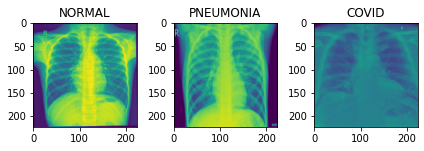

In [ ]:
width=150
height=150
rows = 1
cols = 3

imgs = [ normal_images[0], pneumonia_images[0], covid_images[0]]

axes=[]
fig=plt.figure()

for i in range(rows*cols):
    img = imgs[i]
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img)

axes[0].set_title('NORMAL')
axes[1].set_title('PNEUMONIA')
axes[2].set_title('COVID')
fig.tight_layout()    
plt.show()

In [ ]:
normal_X = []
pneumonia_X = []
covid_X = []
normal_y = []
pneumonia_y = []
covid_y = []
X = []
y = []

for item in normal_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    normal_X.append(img)    
    normal_y.append(CLASSES.index("NORMAL"))   
    X.append(img)    
    y.append(CLASSES.index("NORMAL"))

for item in pneumonia_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    pneumonia_X.append(img)    
    pneumonia_y.append(CLASSES.index("PNEUMONIA"))   
    X.append(img)    
    y.append(CLASSES.index("PNEUMONIA"))

for item in covid_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    covid_X.append(img) 
    covid_y.append(CLASSES.index("COVID"))   
    X.append(img)    
    y.append(CLASSES.index("COVID"))

X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape, y.shape

((6057, 224, 224, 1), (6057,))

In [ ]:
X_train_normal = normal_X[:NORMAL_TRAIN_SAMPLES]
X_train_pneumonia = pneumonia_X[:PNEUMONIA_TRAIN_SAMPLES]
X_train_covid = covid_X[:COVID_TRAIN_SAMPLES]
X_test_normal = normal_X[NORMAL_TRAIN_SAMPLES:]
X_test_pneumonia = pneumonia_X[PNEUMONIA_TRAIN_SAMPLES:]
X_test_covid = covid_X[COVID_TRAIN_SAMPLES:]

y_train_normal = normal_y[:NORMAL_TRAIN_SAMPLES]
y_train_pneumonia = pneumonia_y[:PNEUMONIA_TRAIN_SAMPLES]
y_train_covid = covid_y[:COVID_TRAIN_SAMPLES]
y_test_normal = normal_y[NORMAL_TRAIN_SAMPLES:]
y_test_pneumonia = pneumonia_y[PNEUMONIA_TRAIN_SAMPLES:]
y_test_covid = covid_y[COVID_TRAIN_SAMPLES:]


X_train = np.concatenate((X_train_normal, X_train_pneumonia, X_train_covid), axis=0) 
y_train = np.concatenate((y_train_normal, y_train_pneumonia, y_train_covid), axis=0) 

X_test = np.concatenate((X_test_normal, X_test_pneumonia, X_test_covid), axis=0) 
y_test = np.concatenate((y_test_normal, y_test_pneumonia, y_test_covid), axis=0) 

In [ ]:
# np.full((len(X_train_normal), 1), y_test_normal[0]).shape

In [ ]:
X_train.shape, y_train.shape

((3360, 224, 224, 1), (3360,))

In [ ]:
X_test.shape, y_test.shape

((2697, 224, 224, 1), (2697,))

In [ ]:
a = list(zip(X_train, y_train))
random.shuffle(a)
X_train, y_train = zip(*a)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
# a = list(zip(X_train, y_train))
# random.shuffle(a)
# X_test, y_test = zip(*a)

In [ ]:
X_train.shape, y_train.shape

((3360, 224, 224, 1), (3360,))

In [ ]:
# ----------------------

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=2020)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
X_val = X_test
y_val = y_test

In [ ]:
X_train = np.repeat(X_train[...,], 3, 3)
X_val = np.repeat(X_val[...,], 3, 3)
X_test = np.repeat(X_test[...,], 3, 3)

In [ ]:
X_train.shape, y_train.shape

((3360, 224, 224, 3), (3360,))

In [ ]:
X_test.shape, y_test.shape

((2697, 224, 224, 3), (2697,))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([1200, 2000,  160]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([ 383, 2273,   41]))

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
train_da_args = dict(rescale=1./255, 
               shear_range=0.2,
               zoom_range=0.05,
               width_shift_range=0.05,
               height_shift_range=0.05,
               rotation_range=360,
               #  brightness_range=[0.2,1.0],
               vertical_flip=True,
               horizontal_flip=True)

# val_da_args = dict(rescale=1./255)

train_da = ImageDataGenerator(train_da_args)
# val_da = ImageDataGenerator(val_da_args)

train_da.fit(X_train, augment=True)
# val_da.fit(X_train)

train_gen = train_da.flow(X_train, y_train, batch_size=BATCH_SIZE)
# val_gen = train_da.flow(X_val, y_val)

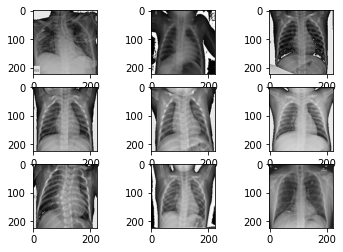

In [ ]:
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][0].astype('uint8')
	pyplot.imshow(image)

pyplot.show()

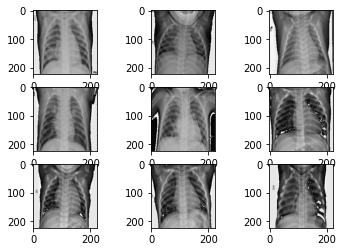

In [ ]:
for i in range(9):
	
	pyplot.subplot(330 + 1 + i)
	batch = train_gen.next()
	image = batch[0][-1].astype('uint8')
	pyplot.imshow(image)

pyplot.show()

In [ ]:
# augmented_data = []
# num_augmented = 0
# for X_batch, y_batch in train_da.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False):
#     augmented_data.append(X_batch)
#     num_augmented += BATCH_SIZE
#     if num_augmented == X_train.shape[0]:
#         break
# augmented_data = np.concatenate(augmented_data)

In [ ]:
# -------------------------

In [ ]:
# len(train_gen.x) 

In [ ]:
# vgg_model = VGG16(weights='imagenet', 
#                         include_top=False, 
#                         input_shape=(IMG_H, IMG_W, 3))

# for layer in vgg_model.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True
#     else:
#         layer.trainable = False

# model = Sequential()
# model.add(vgg_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(NB_CLASSES, activation='softmax'))

In [ ]:
models_input = Input(shape=(IMG_H, IMG_W, 3))


resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in resnet_model.layers:
    layer.name = "resnet50_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
        
resnet_gap = GlobalAveragePooling2D()(resnet_model.output)

# x = Dense(256)(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# x = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(x)
# out = Activation('softmax')(x)
# resnet_model = Model(inputs=resnet_model.input, outputs=out)


vgg_model = VGG16(weights='imagenet', 
                        include_top=False, 
                        input_tensor=models_input)

for layer in vgg_model.layers:
    layer.name = "vgg16_" + layer.name
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

        
vgg_gap = GlobalAveragePooling2D()(vgg_model.output)

# # x = GlobalAveragePooling2D()(vgg_model.output)
# x = Dense(256)(vgg_gap)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Activation('relu')(x)
# vgg_out = BatchNormalization()(x)
# x = Dense(NB_CLASSES)(x)
# out = Activation('softmax')(x)

merged_nets = concatenate([resnet_gap, vgg_gap])

# x = Dense(NB_CLASSES)(merged_nets)
# out = Activation('softmax')(x)

inputs = input_tensor=models_input
outputs = merged_nets # out # average([resnet_model.output, vgg_model.output])
model = Model(inputs, outputs)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_resnet50_input_1 (InputLa (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
resnet50_conv1_pad (ZeroPadding (None, 230, 230, 3)  0           vgg16_resnet50_input_1[0][0]     
__________________________________________________________________________________________________
resnet50_conv1 (Conv2D)         (None, 112, 112, 64) 9472        resnet50_conv1_pad[0][0]         
__________________________________________________________________________________________________
resnet50_bn_conv1 (BatchNormali (None, 112, 112, 64) 256         resnet50_conv1[0][0]             
____________________________________________________________________________________________

In [ ]:
len(train_gen.x) // 60

56

In [ ]:
# # model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
# #           steps_per_epoch=  x_train.shape[0]//batch_size,
# #           epochs=epochs,
# #           verbose=1,
# #           class_weight=class_weight_dic)

# hist = model.fit_generator(train_gen,
#                     steps_per_epoch=len(train_gen.x)//BATCH_SIZE,
#                     epochs=EPOCHS,
#                     validation_data=(X_val, y_val),
#                     validation_steps=X_val.shape[0]//BATCH_SIZE)

In [ ]:
# hist = model.fit(X_train, 
#                  y_train, 
#                  batch_size=BATCH_SIZE, 
#                  epochs=3, 
#                  verbose=1, 
#                  callbacks=None, 
#                  validation_data=(X_val, y_val))

In [ ]:
features, labels = model.predict(X_train), y_train

In [ ]:
features.shape, labels.shape

((3360, 2560), (3360, 3))

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.02, 
                    n_estimators=600, 
                    objective='multi:softmax', 
                    silent=True, 
                    nthread=1)

In [ ]:
y_labels = np.argmax(labels,axis = 1)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import StratifiedKFold


# y_labels = np.argmax(labels,axis = 1) 

# folds = 4
# param_comb = 5

# start = time.time()

# # A parameter grid for XGBoost
# params = {
#         'learning_rate': [0.02, 0.05, 0.1, 0.2],
#         'min_child_weight': [2, 3, 5, 10],
#         'gamma': [0.8, 1, 1.5, 2, 5],
#         'subsample': [0.5, 0.6, 0.7, 0.8],
#         'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
#         'max_depth': [2, 3, 4, 5]
#         }

# xgb = XGBClassifier(learning_rate=0.02, 
#                     n_estimators=600, 
#                     objective='multi:softmax', 
#                     silent=True, 
#                     nthread=1)

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 2020)

# random_search = RandomizedSearchCV(xgb, 
#                                    param_distributions=params, 
#                                    n_iter=param_comb, 
#                                   #  scoring='roc_auc', 
#                                    n_jobs=4, 
#                                    cv=skf.split(features,y_labels), 
#                                    verbose=3, 
#                                    random_state=2020)

# random_search.fit(features, y_labels)

# end = time.time()
# print('Time taken in random search: {0: .2f}'.format(end - start))


In [ ]:
# best_score = random_search.best_score_
# best_params = random_search.best_params_
# print('Best Score using random search: \n', best_score)
# print('Best Parameters using random search: \n', best_params)

In [ ]:
# # # Set best parameters given by random search 
# # xgb = XGBClassifier(learning_rate=0.02, 
# #                     n_estimators=600, 
# #                     objective='multi:softmax', 
# #                     silent=True, 
# #                     nthread=1)
xgb.set_params(subsample=0.6, 
               min_child_weight=10, 
               max_depth=5, 
               gamma=1, 
               learning_rate=0.05,
              #  max_features=None,
               colsample_bytree=0.6)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.6, verbosity=1)

In [ ]:
test_features, test_labels = model.predict(X_test), y_test

In [ ]:
xgb.fit(features, y_labels, eval_metric="error", verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

In [ ]:
predictions_xgb = xgb.predict(test_features)

In [ ]:
y_test_labels = np.argmax(test_labels, axis = 1) 
accuracy_xgb = xgb.score(test_features, y_test_labels)

In [ ]:
print("accuracy : ", accuracy_xgb)

accuracy :  0.957360029662588


In [ ]:
# model.evaluate(X_test, y_test)

In [ ]:
# Confusion matrix
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
    thresh = np.max(cm) // 2 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
# Y_pred = model.predict(X_test)
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Y_true = np.argmax(y_test,axis = 1) 
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [ ]:
# plot_confusion_matrix(confusion_mtx, classes = CLASSES)

In [ ]:
Y_pred = predictions_xgb
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_pred_classes = Y_pred
# Y_true = np.argmax(test_labels,axis = 1) 
Y_true = y_test_labels
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

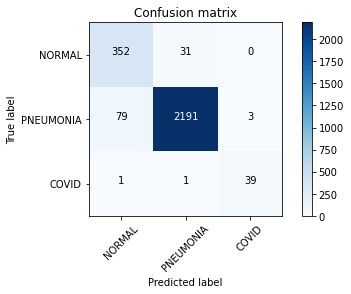

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = CLASSES)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


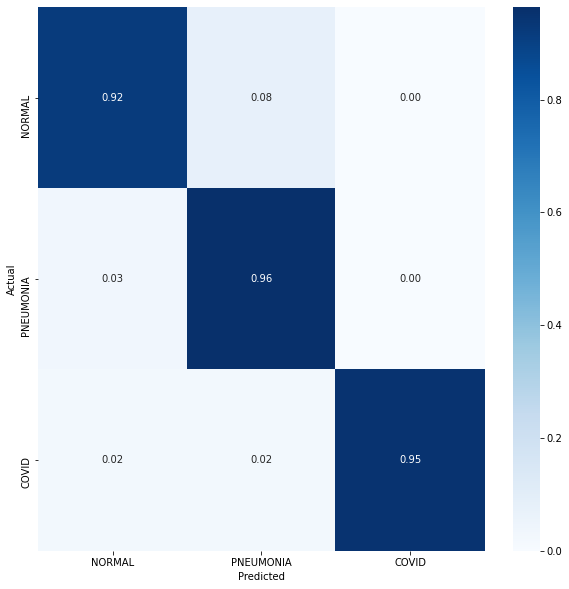

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# Normalise
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       383
           1       0.99      0.96      0.97      2273
           2       0.93      0.95      0.94        41

    accuracy                           0.96      2697
   macro avg       0.91      0.94      0.93      2697
weighted avg       0.96      0.96      0.96      2697



In [ ]:
model.save_weights('Covid19_Detection_pretrained_VGG_Resnet_XGB.h5')

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='Covid19_Detection_pretrained_VGG_Resnet_XGB.png')

### Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=2020)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# np.random.seed(2020)
# start = time.time()

# param_dist = {'max_depth': [2, 3, 4],
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt', 'log2', None],
#               'criterion': ['gini', 'entropy']}

# cv_rf = GridSearchCV(rf_clf, cv = 2,
#                      param_grid=param_dist, 
#                      n_jobs = 3)

# cv_rf.fit(features, labels)
# print('Best Parameters using grid search: \n', cv_rf.best_params_)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

In [ ]:
# Set best parameters given by grid search 
rf_clf.set_params(bootstrap=True, criterion='entropy', max_depth=4, max_features=None)

In [ ]:
rf_clf.fit(features, labels)

In [ ]:
test_features, test_labels = model.predict(X_test), y_test

In [ ]:
predictions_rf = rf_clf.predict(test_features)

In [ ]:
accuracy_rf = rf_clf.score(test_features, test_labels)

In [ ]:
print("accuracy : ", accuracy_rf)